# IMDM 영화평 분석

## 지도학습 기반

### 데이터 로딩 및 확인

In [1]:
import pandas as pd

review_df = pd.read_csv('./dataset/labeledTrainData.tsv', sep='\t',)
print(review_df.shape)
print(review_df.head())

(25000, 3)
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


### 데이터 전처리
- br 태그 삭제
- 알파벳이 아닌 문자 삭제 

In [2]:
# print(review_df['review'][0])
import re 
review_df['review'] = review_df['review'].str.replace('<br />',' ')   # str 쓰면 replace 사용 가능
review_df['review'] = review_df['review'].apply(lambda x:re.sub('[^a-zA-Z]',' ', x))

In [3]:
print(review_df['review'][0])

With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay   Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him   The actual feature film bit when it finally starts is only on for   

### 학습 데이터/평가 데이터 분리

In [4]:
x = review_df['review']
y = review_df['sentiment']

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100, stratify=y)
print(x_train.shape, x_test.shape)

(17500,) (7500,)


### 피처 벡터화

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

cnt_vect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2))
cnt_vect.fit(x_train)
x_train_cnt_vect = cnt_vect.transform(x_train)
x_test_cnt_vect = cnt_vect.transform(x_test)

### 모델 학습 및 평가

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression(solver='liblinear', C=10)
lr_clf.fit(x_train_cnt_vect, y_train)

y_hat = lr_clf.predict(x_test_cnt_vect)
pred_prob = lr_clf.predict_proba(x_test_cnt_vect)
print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, pred_prob[:,1]):.3f}')

정확도:0.888
AUC:0.951


# 비지도학습 기반 감성 분석

## WordNet Synset과 SentiWordNet SentiSynset 클래스의 이해

In [ ]:
import nltk
# NLTK의 모든 데이터 셋과 패키지를 다운로드
# nltk.download('all')

### WordNet 주요 기능 확인
- WordNet은 시맨틱(문맥상 의미)분걱을 제공하는 어휘 사전이다.
- synset(): 하나의 단어가 가질 수 있는 여러 가지 시맨틱 정보를 Synset 객체로 변환
- Synset 객체 형식 (aaaa.b.c 형식): aaaa -> 단어 이름, b -> 품사, c -> 같은 품사 그룹의 인덱스

In [8]:
from nltk.corpus import wordnet as wn

term = 'present'
synsets = wn.synsets(term)
print(type(synsets))
print(len(synsets))
print(synsets)

<class 'list'>
18
[Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


In [9]:
for synset in synsets:
    print(f'#### Synset name: {synset.name()} ####')
    print(f'POS:{synset.lexname()}')
    print(f'Definition:{synset.definition()}')
    print(f'Lemma:{synset.lemma_names()}')
    print()

#### Synset name: present.n.01 ####
POS:noun.time
Definition:the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemma:['present', 'nowadays']

#### Synset name: present.n.02 ####
POS:noun.possession
Definition:something presented as a gift
Lemma:['present']

#### Synset name: present.n.03 ####
POS:noun.communication
Definition:a verb tense that expresses actions or states at the time of speaking
Lemma:['present', 'present_tense']

#### Synset name: show.v.01 ####
POS:verb.perception
Definition:give an exhibition of to an interested audience
Lemma:['show', 'demo', 'exhibit', 'present', 'demonstrate']

#### Synset name: present.v.02 ####
POS:verb.communication
Definition:bring forward and present to the mind
Lemma:['present', 'represent', 'lay_out']

#### Synset name: stage.v.01 ####
POS:verb.creation
Definition:perform (a play), especially on a stage
Lemma:['stage', 'present', 'represent']

#### Synset name: present.v.04 ####
POS:verb

- Synset 객체의 path_similarity() 함수를 통해 단어의 상호 유사도를 확인할 수 있다.

In [10]:
import pandas as pd

tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')
entities = [tree, lion, tiger, cat, dog]
similaities = []
entity_names = [ entity.name().split('.')[0] for entity in entities]
# 각 단어에 대한 상호 유사도 계산
import numpy as np
# entity: 기준이 되는 단어
for entity in entities:
    similarity = [ np.round(entity.path_similarity(compared_entity), 2) for compared_entity in entities]
    similaities.append(similarity)  # 자기 자신도 포함하기 때문에 대각행렬 (자기자신과는 1), 정방행렬 만들어짐
similarity_df = pd.DataFrame(similaities, columns=entity_names, index=entity_names)
print(similarity_df)

       tree  lion  tiger   cat   dog
tree   1.00  0.07   0.07  0.08  0.12
lion   0.07  1.00   0.33  0.25  0.17
tiger  0.07  0.33   1.00  0.25  0.17
cat    0.08  0.25   0.25  1.00  0.20
dog    0.12  0.17   0.17  0.20  1.00


### SentiWordNet의 주요 기능 확인
- WordNet과 유사한 기능을 갖는 모듈
- 추가로 단어의 감성을 나타내는 `감성 지수`와 객관성을 나타내는 `객관성 지수`를 제공한다.

In [11]:
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print(type(senti_synsets))
print(len(senti_synsets))
print(senti_synsets)

<class 'list'>
11
[SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


In [12]:
father = swn.senti_synset('father.n.01')
print('긍정감성 지수:', father.pos_score())
print('부정감성 지수:', father.neg_score())
print('객관성 지수:', father.obj_score())

긍정감성 지수: 0.0
부정감성 지수: 0.0
객관성 지수: 1.0


In [13]:
fabulous = swn.senti_synset('fabulous.a.01')
print('긍정감성 지수:', fabulous.pos_score())
print('부정감성 지수:', fabulous.neg_score())
print('객관성 지수:', fabulous.obj_score())

긍정감성 지수: 0.875
부정감성 지수: 0.125
객관성 지수: 0.0


## SentiWordNet을 이용한 영화 감상평 감성 분석
- 분석 절차
  1. 문서를 문장 단위로 분해
  2. 문장을 단어 단위로 토큰
  3. 토큰화된 단어의 어근 추출 및 품사 태깅
  4. SentiWordNet을 이용하여 긍정/부정 감성 지수 구하고, 이를 모두 합산하여 특정 임계치 이상일 경우 긍정으로, 그렇지 않으면 부정으로 분류

### WordNet 기반의 품사 태그 반환함수 정의
- POS Table

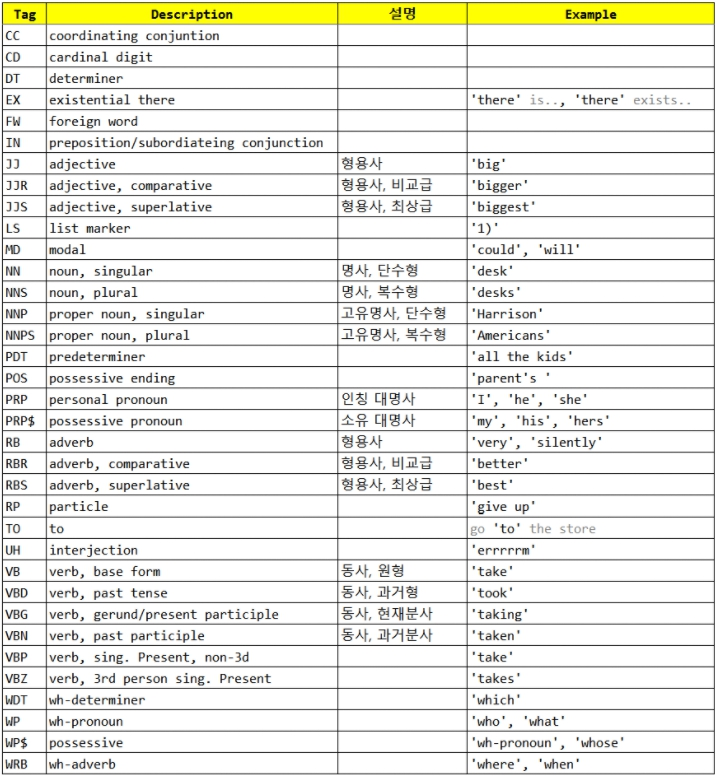

In [14]:
from nltk.corpus import wordnet as wn

# NLTK PennTreeBank Tag를 기반으로 WordNet의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB

- 감성지수 변환 함수 정의
>- 각 단어의 긍정 감성 지수와 부정 감성 지수를 모두 합한 총 감성 지수가 0 이상일 경우 긍정 감성(1), 그렇지 않으면 부정 감성(0) 값 변환

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    sentiment = 0.0 # 감성 지수 초기화
    token_count = 0
    lemmatizer = WordNetLemmatizer() # 어근 추출
    sentences = sent_tokenize(text)
    for sentence in sentences:
        word_tokens = word_tokenize(sentence)
        # pos_tag() : 품사 분류, 단어와 품사를 값으로 갖는 튜플 반환
        tagged_sentence = pos_tag(word_tokens)
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag) # WordNet 기반의 품사로 변환
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word,pos=wn_tag)
            if not lemma: # 해당하는 어근이 존재하지 않으면 pass
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0] # 여러 Synset객체 중 가장 첫 번째 단어의 문맥을 대표 Synset 객체로 선택
            swn_synset = swn.senti_synset(synset.name()) # synset.name() -> 'father.n.01' 형식 값 반환
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
            token_count += 1
            
    if not token_count:
        return 0
    if sentiment >= 0:
        return 1

    return 0

- swn_polarity() 함수 구조 파악 테스트

In [22]:
text = review_df['review'][0]
# print(text)
sentences = sent_tokenize(text)
# print(len(sentences))
# print(sentences[0])
tagged = pos_tag(word_tokenize(sentences[0]))
print(len(tagged))
print(tagged[0])

437
('With', 'IN')


### 리뷰에 대한 감성지수 값을 예측 값으로 계산

In [23]:
review_df['preds'] = review_df['review'].apply(lambda x:swn_polarity(x))

### 예측 정확도 확인 

In [24]:
y_target = review_df['sentiment'].values # 정답
y_hat = review_df['preds'].values # 예측값

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print(confusion_matrix(y_target, y_hat))
print(f'정확도:{accuracy_score(y_target, y_hat):.3f}')
print(f'정밀도:{precision_score(y_target, y_hat):.3f}')
print(f'재현율:{recall_score(y_target, y_hat):.3f}')

[[7668 4832]
 [3636 8864]]
정확도:0.661
정밀도:0.647
재현율:0.709


# VADER를 이용한 감성 분석
- 소셜 미디어의 감성 분석 용도로 만들어진 감성 사전
- SentimentIntensityAnalyzer 객체 이용
- polarity_scores() 함수: 딕셔너리 형태의 감성 점수 반환
>- neg: 부정 감성 지수
>- neu: 중립 감성 지수
>- pos: 긍정 감성 지수
>- compound: neg, neu, pos를 적절하게 조합해서 만든 -1 ~ 1 사이의 감성 지수 (0.1 이상이면 긍정 감성, 미만이면 부정 감성 판단)

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_score = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_score)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


## 긍정/부정 판별 함수 정의

In [28]:
def vader_polarity(review, thershold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(review)
    agg_score = score['compound']  # 딕셔너리 값으로 나오기 때문에 compound만 가지고 옴
    final_sentiment = 1 if agg_score >= thershold else 0
    return final_sentiment

In [29]:
review_df['vader_preds'] = review_df['review'].apply(lambda x:vader_polarity(x))

In [32]:
y_target = review_df['sentiment'].values # 정답
y_hat = review_df['vader_preds'].values # 예측값

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print(confusion_matrix(y_target, y_hat))
print(f'정확도:{accuracy_score(y_target, y_hat):.3f}')
print(f'정밀도:{precision_score(y_target, y_hat):.3f}')
print(f'재현율:{recall_score(y_target, y_hat):.3f}')

[[ 6747  5753]
 [ 1858 10642]]
정확도:0.696
정밀도:0.649
재현율:0.851
